In [ ]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
import torch
import glob

from pathlib import PurePath
from IPython import display

import vxs
import vxs.utils as vxsu

In [2]:
MB_DATA_DIR = PurePath('../data/mehrabi-eval/data')
responses_data = pd.read_csv(MB_DATA_DIR / 'listening_test_responses.csv')
responses_data

,listener,imitator,imitated_sound,rated_sound,rating,duplicate_flag
0,12,6,20,19,0,0
1,12,6,20,18,0,0
2,12,6,20,21,41,0
3,12,6,20,20,40,0
4,12,6,20,23,0,0
...,...,...,...,...,...,...
11335,7,6,21,18,31,1
11336,7,6,21,21,22,1
11337,7,6,21,20,9,1
11338,7,6,21,23,64,1


### Determine reliable listeners (spearman's rank >= 0.5)

In [21]:
def assess_reliability(listener):
    df = responses_data[responses_data['listener'] == listener]
    print(listener, len(df))
    return df

In [16]:
listeners = sorted(responses_data['listener'].unique())

### Take a look at the sounds

In [24]:
drum_sounds = vxs.SampleSet(MB_DATA_DIR / 'drum_sounds/*.wav', wave_only=True)

In [39]:
imitated_sounds_0 = vxs.SampleSet(MB_DATA_DIR / 'imitations/imitator_0/*.wav', wave_only=True)

In [36]:
def plot_play(ds, limit=None):
    if limit is None:
        limit = len(ds)

    for i in range(limit):
        print(f'sound {ds[i].filepath}')
        vxsu.plot_track(ds[i])
        display.display(vxsu.play_audio(ds[i]))

sound ../data/mehrabi-eval/data/drum_sounds/0.wav


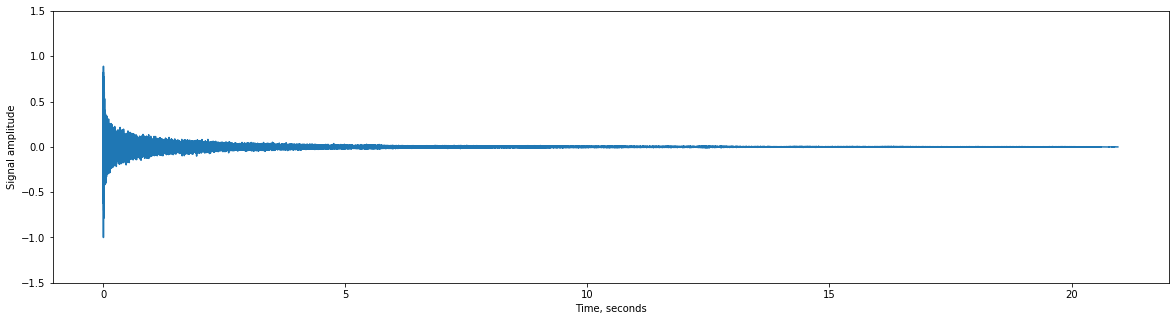

sound ../data/mehrabi-eval/data/drum_sounds/18.wav


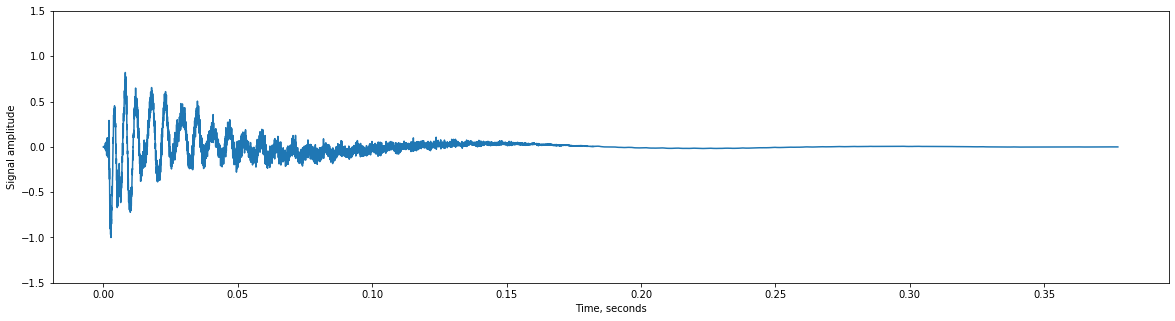

sound ../data/mehrabi-eval/data/drum_sounds/19.wav


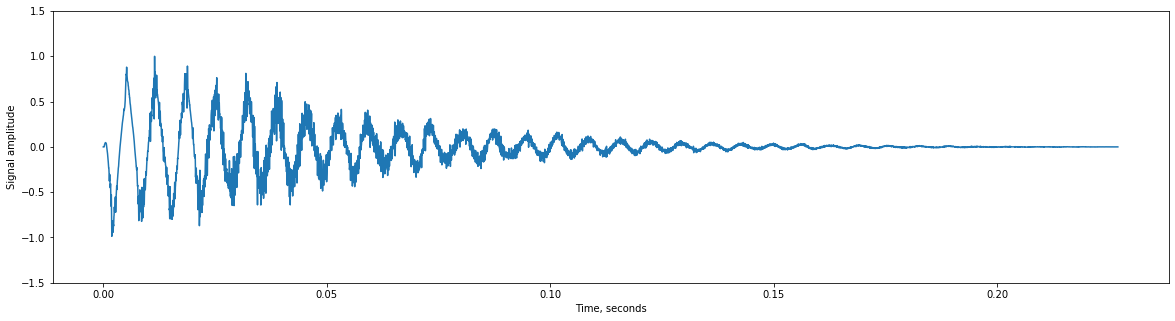

In [41]:
plot_play(drum_sounds, 3)

sound ../data/mehrabi-eval/data/imitations/imitator_0/0.wav


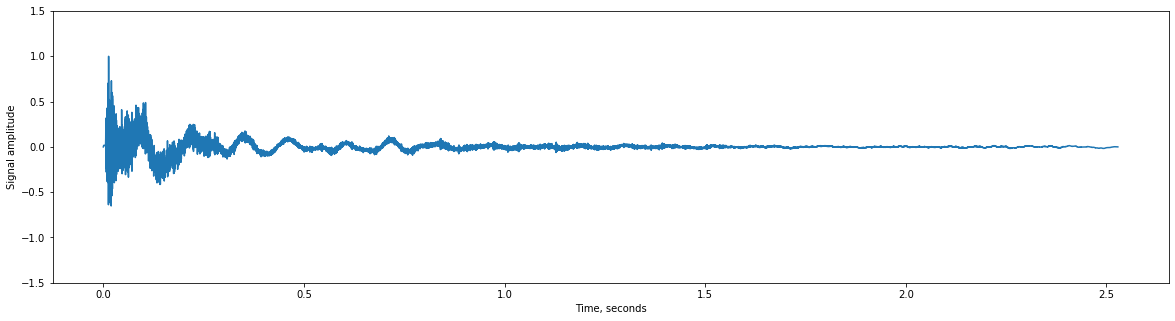

sound ../data/mehrabi-eval/data/imitations/imitator_0/18.wav


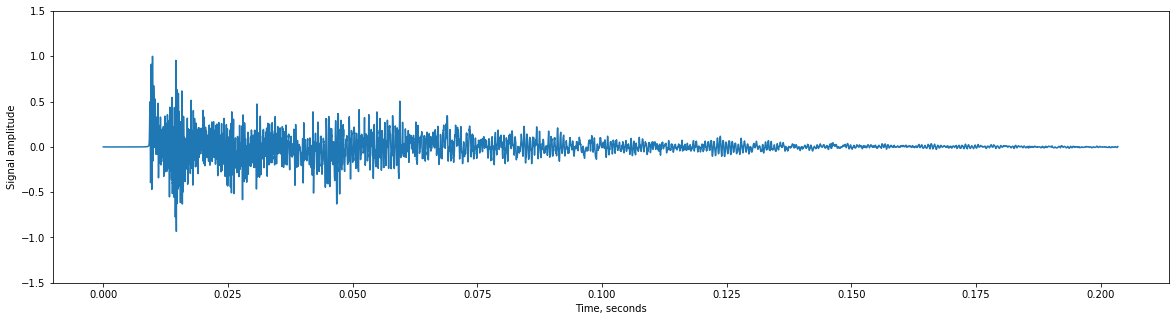

sound ../data/mehrabi-eval/data/imitations/imitator_0/19.wav


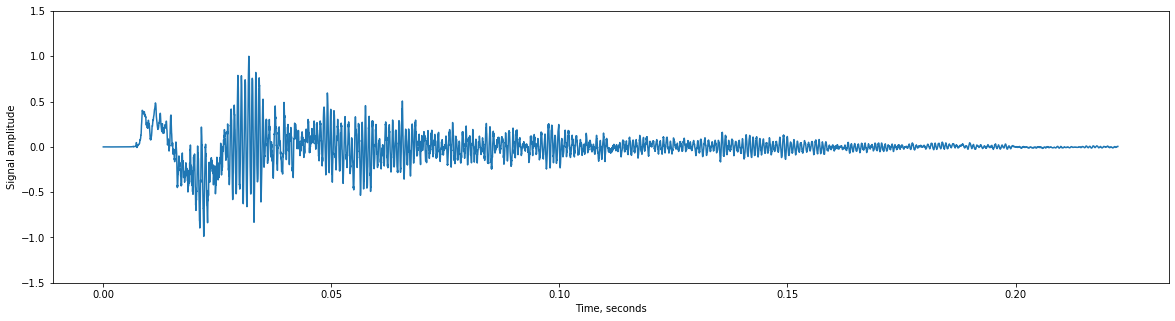

In [42]:
plot_play(imitated_sounds_0, 3)